# Insight 18B Data Challenge 1

__Notes about this assignment:__  

*Time limit = 4 hours*  

**Goal: Develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.**  

Some important questions to think about are:  
* How can you best explore the data?  
* Why did you select your particular model?  
* How did you validate your model?  
* What insights can you derive from your results?  

**Variables in Dataset**: 
* id number  
* Clump Thickness: 1 - 10  
* Uniformity of Cell Size: 1 - 10  
* Uniformity of Cell Shape: 1 - 10  
* Marginal Adhesion: 1 - 10  
* Single Epithelial Cell Size: 1 - 10  
* Bare Nuclei: 1 - 10  
* Bland Chromatin: 1 - 10  
* Normal Nucleoli: 1 - 10  
* Mitoses: 1 - 10  
* Class: (2 for benign, 4 for malignant)

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
#import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
#from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold # import KFold
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:



def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()



def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [5]:
# Import data and add column names: 
# id number
# Clump Thickness: 1 - 10
# Uniformity of Cell Size: 1 - 10
# Uniformity of Cell Shape: 1 - 10
# Marginal Adhesion: 1 - 10
# Single Epithelial Cell Size: 1 - 10
# Bare Nuclei: 1 - 10
# Bland Chromatin: 1 - 10
# Normal Nucleoli: 1 - 10
# Mitoses: 1 - 10
# Class: (2 for benign, 4 for malignant)

df_raw = pd.read_csv('breast-cancer-wisconsin.csv', 
                     names = ['id', 'thickness', 'uni_size', 'uni_shape',
                              'adhesion', 'epi_size', 'bare_nuc', 
                              'bland_chrom', 'norm_nuc', 'mitoses', 
                              'class'])
df_raw.head()

,id,thickness,uni_size,uni_shape,adhesion,epi_size,bare_nuc,bland_chrom,norm_nuc,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Inspect and explore variables

In [28]:
print(df_raw.shape)
df_raw.describe()

(699, 11)


,id,thickness,uni_size,uni_shape,adhesion,epi_size,bland_chrom,norm_nuc,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [19]:
df_raw.describe(include='O')

,bare_nuc
count,699
unique,11
top,1
freq,402


In [7]:
# MAke copy of df
df = df_raw
df.dtypes

id              int64
thickness       int64
uni_size        int64
uni_shape       int64
adhesion        int64
epi_size        int64
bare_nuc       object
bland_chrom     int64
norm_nuc        int64
mitoses         int64
class           int64
dtype: object

## Fix some of the variables  
* Recode '?' to nan for **bare_nuc** variable.  
* Recode **class** variable to be 1s and 0s.

In [37]:
df['bare_nuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [8]:
# There appears to be a question mark. Coerce to float so
# the question mark becomes NaN.
df[['bare_nuc']] = df[['bare_nuc']].apply(pd.to_numeric, errors='coerce')
print(df['bare_nuc'].unique())
df.describe()

[ 1. 10.  2.  4.  3.  9.  7. nan  5.  8.  6.]


,id,thickness,uni_size,uni_shape,adhesion,epi_size,bare_nuc,bland_chrom,norm_nuc,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [9]:
#### Recode class as 0 (benign) and 1 (malignant): (because that makes
# more sense and also intercept will make sense if I decide to go the 
# logistic regression route)
df.loc[df['class'] < 3, 'class'] = 0
df.loc[df['class'] > 3, 'class'] = 1

## Explore dependent variables
It is always good practice to visualize your variables before running any models. A histogram plot will help me get a sense for the distribution of the variables.  

In [22]:
def plot_histograms( df , variables , n_rows , n_cols ):
    '''
    Plot histogram of specified variables in grid.
    '''
    fig = plt.figure( figsize = ( 16 , 24 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( str( var_name ) )
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

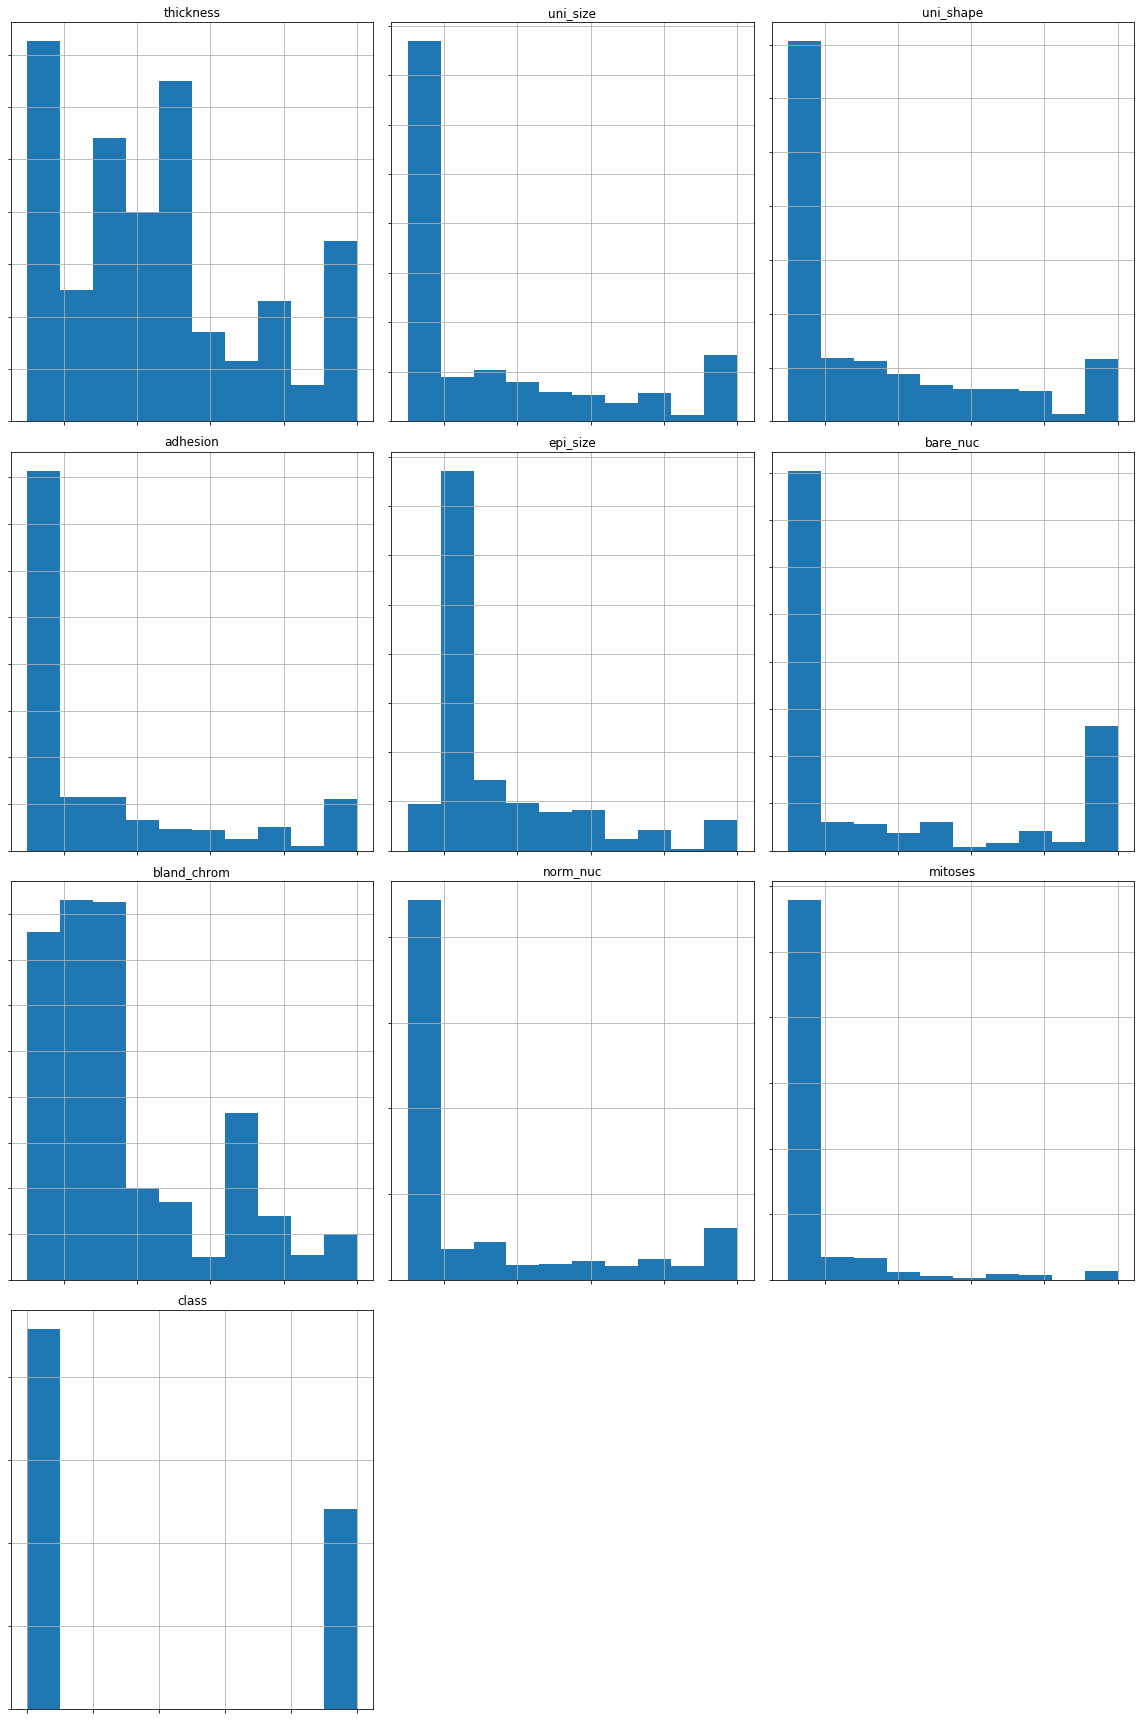

In [23]:
plot_histograms(df, ['thickness', 'uni_size', 'uni_shape',
                        'adhesion', 'epi_size', 'bare_nuc',
                    'bland_chrom', 'norm_nuc', 'mitoses', 
                    'class'], 4, 3)

In [29]:
### What percentage of observations belong to classes 1 and 0?
df['class'].value_counts(normalize=True)

0    0.655222
1    0.344778
Name: class, dtype: float64

#### Some problems with the data thus far: 
* Almost all variables are skewed.  
* Class imbalance is not severe, although it might be something to consider when weighing different model performance metrics later on.    
* bare_nuc variable is missing 16 observations. This is such a small percentage of the total number of observations, that it doesn't really matter. However, I will opt to keep those, and simply replace the missing value with the mode of bare_nuc (because the variable is so skewed, using the mean or median is not ideal).  

In [10]:
# Impute missing bare_nuc values: set missing to mode
from statistics import mode
df['bare_nuc'] = df['bare_nuc'].fillna(mode(df['bare_nuc']))

## Split Data into Test and Training Datasets:
**Training-Test Split**: 80% Training, 20% Test

In [11]:
# Create training and testing datasets
# (Note: can feed it multiple datasets at once as long as they all have same number of rows)
# (specifying random_state ensures that you'll be able to recreate the same test set each time you rerun code)
df_train, df_test = train_test_split(df, 
                                     test_size = 0.2,
                                     random_state=156)

### Make combined dataset to facilitate applying variable changes to both datasets
df_full = df_train.append(df_test, ignore_index = True) 
#df_train = df_full[:(len(data_split_train))] # Training data set

print(df_train.shape, df_test.shape, df_full.shape)


(559, 11) (140, 11) (699, 11)


## Return to Variable Exploration
Look at the correlations among the variables.

In [2]:
import seaborn as sns

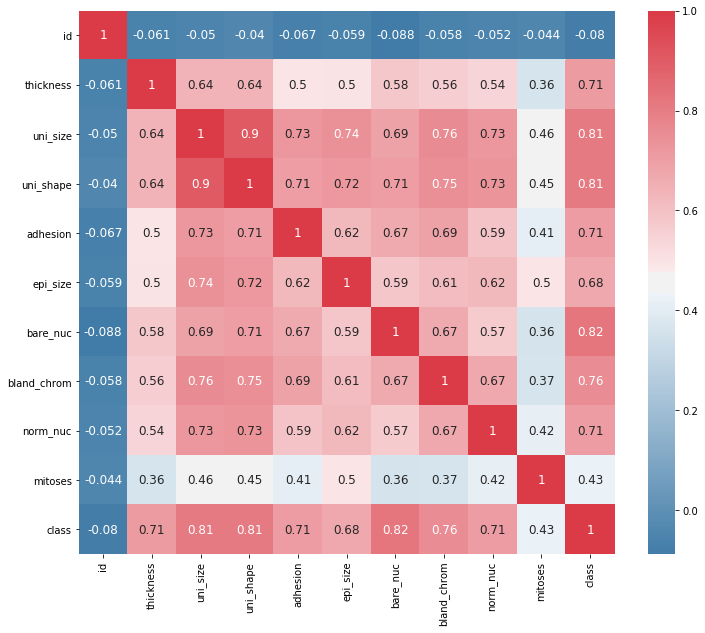

In [42]:
ax = plt.subplots( figsize =(12, 10) ) # change plot size
sns.heatmap(df_train.corr(), # correlation matrix of all vars in df_train
           annot=True, # add labels to matrix
           cmap = sns.diverging_palette(240, # change colors to blue and red
                                        10, 
                                        as_cmap=True),
            annot_kws = { 'fontsize' : 12 } # font size
           )

**Notes about Correlations:**  

**Multicollinearity** seems to be fairly prevalent in this dataset. e.g., `uni_shape` and `uni_size` are correlated at .9. The dimensions could probably be reduced (e.g., via **PCA**). If I used PCA, this would allow me to use a **logistic regression** model (using the PCA principle components). However, this is not ideal if we want to know which variables are important in predicting cancer (since the logistic regression coefficients will only tell us which PCA components are important).

For this reason, it seems that a model such as **random forest** would be best, because it is capable of handling correlated variables (the "feature importances" are no longer interpretable with such highly correlated features when using logistic regression). 

### Data Visualization

In [22]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , 
                          hue=target , 
                          aspect=4 , # aspect ratio of plot
                          row = row , 
                          col = col )
    facet.map( sns.kdeplot , var , shade= True ) 
        # kdeplot = kernel density estimate
    facet.set( xlim=( 1 , df[ var ].max() ) )
    facet.add_legend()

In [ ]:
def

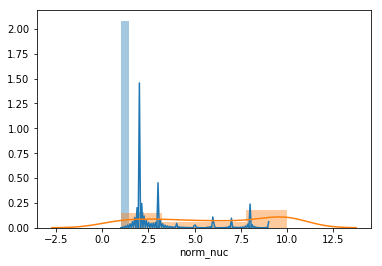

In [20]:
sns.distplot(
    df_train.loc[df_train['class']==0]['norm_nuc'], )
sns.distplot(
    df_train.loc[df_train['class']==1]['norm_nuc'], )

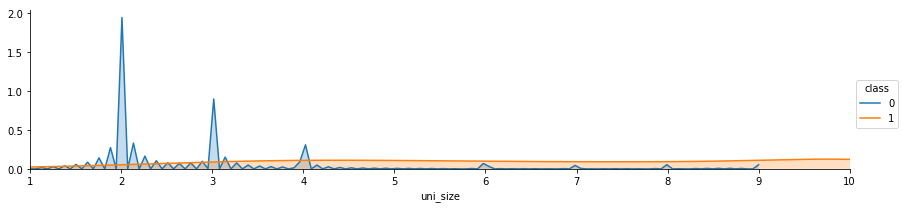

In [23]:
plot_distribution(df_train, var='uni_size', target='class')

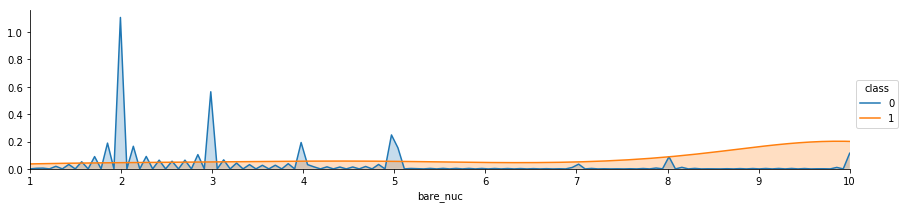

In [24]:
plot_distribution(df_train, var='bare_nuc', target='class')

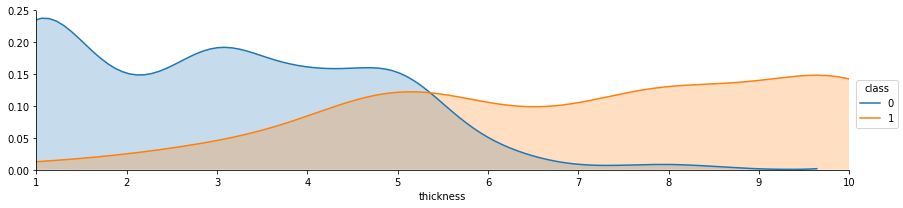

In [25]:
plot_distribution(df_train, var='thickness', target='class')

#### Summary of visualizations: 
It's fairly apparent already that these features are doing a good job of predicting cancer vs. non-cancer cells. 

### Fix non-normal distributions by making them categorical

In [16]:
#### Turn really skewed variables into binary categories: 
def make_var_binary(df, variable_list=[], split_under=2): 
    
    df_recoded = df
        
    for variable in variable_list:
        
        df_recoded[variable] = df_recoded[variable].mask(df_recoded[variable] < split_under, 0)
        df_recoded[variable] = df_recoded[variable].mask(df_recoded[variable] >= split_under, 1)

    return df_recoded


In [17]:
skewed_1_var_list = ['uni_size', 'uni_shape', 'adhesion', 'bare_nuc', 'norm_nuc', 'mitoses']

df_train_recoded = make_var_binary(df_train, variable_list=skewed_1_var_list)
df_train_recoded.head()

,id,thickness,uni_size,uni_shape,adhesion,epi_size,bare_nuc,bland_chrom,norm_nuc,mitoses,class
657,1333877,5,1,1,0,8,0.0,3,1,0,0
52,1110102,10,1,1,1,3,1.0,4,1,1,1
258,1198641,3,0,0,0,2,0.0,3,0,0,0
41,1099510,10,1,1,0,3,1.0,6,1,1,1
454,1238410,2,1,0,0,3,0.0,1,0,0,0


In [18]:
### Deal with variable that is skewed at 2 instead of 1
skewed_2_var_list = ['epi_size']

df_train_recoded = make_var_binary(df_train_recoded, 
                                   variable_list=skewed_2_var_list, split_under=3)

df_train_recoded.head()

,id,thickness,uni_size,uni_shape,adhesion,epi_size,bare_nuc,bland_chrom,norm_nuc,mitoses,class
657,1333877,5,1,1,0,1,0.0,3,1,0,0
52,1110102,10,1,1,1,1,1.0,4,1,1,1
258,1198641,3,0,0,0,0,0.0,3,0,0,0
41,1099510,10,1,1,0,1,1.0,6,1,1,1
454,1238410,2,1,0,0,1,0.0,1,0,0,0


In [19]:
### Repeat for test set: 
df_test_recoded = make_var_binary(df_test, variable_list=skewed_1_var_list)
df_test_recoded = make_var_binary(df_test_recoded, 
                                   variable_list=skewed_2_var_list, split_under=3)
df_test.head()

,id,thickness,uni_size,uni_shape,adhesion,epi_size,bare_nuc,bland_chrom,norm_nuc,mitoses,class
301,636130,1,0,0,0,0,0.0,3,0,0,0
375,636437,1,0,0,0,0,0.0,1,0,0,0
233,1232225,10,1,1,1,1,1.0,4,0,0,1
295,606722,5,1,1,1,1,1.0,7,1,0,1
688,603148,4,0,0,0,0,0.0,1,0,0,0


In [ ]:
### should look at things now, but must move on! 

# Modeling

## Model Preparation
- First get datasets together and split up the training/validation and test sets

In [20]:
### Redundant variables: Rotate ones on this list with the ones in the model for comparison
#varDropList = ['uni_shape'] # Variables that don't make sense to include 
#X_train = df_train.drop(varDropList_)
# df_full_num = df_full.drop(varDropList_uncoded, axis=1)
# X_full = pd.concat([df_full_num.drop('is_open', axis=1), df_full_enc], axis=1)
# X_full = X_full.drop(varDropList_doubles, axis=1)
# #X_full = X_full.drop(varDropList_uncoded, axis=1)
# print(len(list(X_full)))
# X_full.head()

In [ ]:
### Create datasets to train, validate, and test models: 

### Train/Validate:
y_train_valid = df_train_recoded['class']
X_train_valid = df_train_recoded.drop('class')

### Test datasets:
y_test = df_test_recoded['class']
X_test = df_test_recoded.drop('class')
#y_test_forreal = df_full[]

### Make validation and training datasets: 
train_x , valid_x , train_y , valid_y = train_test_split(X_train_valid, 
                                                         y_train_valid, 
                                                         test_size = .2, 
                                                        random_state=88)
print(X_full.shape, df_train.shape, X_test.shape, train_X.shape, 
      valid_X.shape, train_y.shape, valid_y.shape)


In [ ]:
### Super cool functions: 

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 22 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
